In [1]:
import warnings
import scanpy as sc
import numpy as np
import pandas as pd
from joblib import Parallel, delayed
import time
import sys
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from scipy.sparse import csr_matrix
from scipy.stats import hypergeom
from scipy.stats import pearsonr

import matplotlib.cm as cm
import matplotlib.colors as mcolors 
import time


sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

pd.set_option('display.max_rows', 100)
sc.set_figure_params(figsize=(20, 4))

/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/_utils/__init__.py:33: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  from anndata import __version__ as anndata_version
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/__init__.py:24: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):
/Users/rzhu/miniconda3/envs/deseq/lib/python3.11/site-packages/scanpy/readwrite.py:16: FutureWarning: `__version__` is deprecated, use `importlib.metadata.version('anndata')` instead.
  if Version(anndata.__version__) >= Version("0.11.0rc2"):


In [2]:
adata_de = sc.read_h5ad('../../../../3_expts/processed_data/CD4i_final//DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad', backed='r')
adata_final = sc.read_h5ad('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering.h5ad', backed='r')
de_by_guide = pd.read_csv('../3_DE_analysis/results/DE_by_guide.correlation_results.csv', index_col=0)
donor_robustness_summary = pd.read_csv('../3_DE_analysis/results/DE_donor_robustness_correlation_summary.csv', index_col=0)
de_summary_stats = pd.read_csv('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/DE_summary_stats_per_target_corrected.csv', index_col=0)

In [11]:
de_by_guide[de_by_guide.target=='CD3G']

,target,correlation,correlation_ceiling,n_signif,culture_condition
1098,CD3G,0.835491,0.87479,4440,Stim8hr


In [3]:
num_of_cluster = len(adata_final.obs['hdbscan'].unique())
cluster_name = []
corr = []
cluster_size = []
cluster_gene_size = []
cluster_member = []
for i, cl in enumerate(adata_final.obs['hdbscan'].unique()):
    df = pd.DataFrame(data=adata_final[adata_final.obs['hdbscan']==cl].layers['zscore'],
                        index=adata_final[adata_final.obs['hdbscan']==cl].obs_names,
                        columns=adata_final.var_names)
    df_corr = df.T.corr()
    np.fill_diagonal(df_corr.values, 0)
    cluster_name.append(int(cl))
    corr.append(np.mean(df_corr))
    cluster_size.append(len(df))
    cluster_gene_size.append(len(adata_final[adata_final.obs['hdbscan']==cl].obs.target_contrast_gene_name_corrected.unique()))
    cluster_member.append(adata_final[adata_final.obs['hdbscan']==cl].obs.target_contrast_gene_name_corrected.unique().tolist())

cluster_df = pd.DataFrame({'cluster': cluster_name,
                           'intracluster_corr': corr,
                           'cluster_size': cluster_size,
                           'cluster_gene_size': cluster_gene_size,
                           'cluster_member': cluster_member})

In [4]:
import gseapy
from gseapy import Msigdb
from gseapy import barplot, dotplot

msig = Msigdb()
kegg_gene_sets = msig.get_gmt(category= 'c2.cp.kegg_legacy', dbver="2025.1.Hs")
reactome_gene_sets = msig.get_gmt(category= 'c2.cp.reactome', dbver="2025.1.Hs")

In [5]:
corum_df = pd.read_csv('../../../../2_files/enrichment_analysis/CORUM/corum_humanComplexes.txt', delimiter='\t', index_col='complex_id')
stringdb = pd.read_csv('../../../../2_files/enrichment_analysis/STRINGDB/9606.clusters.proteins.v12.0.txt.gz', delimiter='\t', compression='gzip')
protein_info = pd.read_csv('../../../../2_files/enrichment_analysis/STRINGDB/9606.protein.info.v12.0.txt.gz', delimiter='\t', compression='gzip')
cluster_info = pd.read_csv('../../../../2_files/enrichment_analysis/STRINGDB/9606.clusters.info.v12.0.txt.gz', delimiter='\t', compression='gzip')
stringdb_df = pd.merge(stringdb, protein_info, left_on='protein_id', right_on='#string_protein_id')
stringdb_df = pd.merge(stringdb_df, cluster_info, left_on='cluster_id', right_on='cluster_id')
stringdb_df = stringdb_df[stringdb_df.cluster_size<1000].copy()
zhang_df = pd.read_csv('../../../../2_files/enrichment_analysis/Zhang_et_al_2025/final_predictions_80.tsv', delimiter='\t', skiprows=28, header=0)

corum_complexes = {}
for _, row in corum_df.iterrows():
    complex_name = row['complex_name']
    subunits = set(row['subunits_gene_name'].split(';'))
    corum_complexes[complex_name] = subunits

stringdb_complexes = {}
for cluster_id in stringdb_df.cluster_id.unique():
    stringdb_complexes[cluster_id] = set(stringdb_df[stringdb_df.cluster_id==cluster_id].preferred_name)

zhang_complexes = {}
for gene in list(set(zhang_df[['Name1','Name2']].values.flatten())):
    zhang_complexes[gene] = set(zhang_df[(zhang_df.Name1==gene)|(zhang_df.Name2==gene)][['Name1','Name2']].values.flatten())

zhang_pairwise_complexes = {}
for i, row in zhang_df.iterrows():
    zhang_pairwise_complexes['complex '+str(i)] = set([row['Name1'], row['Name2']])

In [6]:
def assess_complex_enrichment(df, complexes, cluster_label, gene_name_label):
    """
    Assess pathway/complex enrichment
    """
    de_genes_per_cluster = {}
    clusters = df[cluster_label].unique()
    for cluster in clusters:
        cluster_genes = df[df[cluster_label]==cluster][gene_name_label]
        de_genes_per_cluster[cluster] = set(cluster_genes)

    N = len(df[gene_name_label].unique())
    
    best_result = []
    all_result = []
    for cluster, de_genes in de_genes_per_cluster.items():
        n = len(de_genes)
        best_result_for_cluster = None # Initialize a variable to track the best result for this cluster
        for complex_name, subunits in complexes.items():
            K = len(subunits)
            # Find the overlap between DE genes and complex subunits
            overlap = de_genes.intersection(subunits)
            k = len(overlap)
            
            # Calculate the p-value
            if (n > 0 and K > 0) and (k > 1): # Avoid division by zero or trivial cases
                pval = hypergeom.sf(k - 1, N, K, n) # sf is survival function
                
                # Adjust for multiple testing (e.g., using Benjamini-Hochberg)
                # This is a crucial step to avoid false positives
                # Store raw p-values and correct later
                current_result = {
                    'cluster': cluster,
                    'complex': complex_name,
                    'overlap_genes': list(overlap),
                    'overlap_fraction': len(overlap)/n,
                    'raw_p_value': pval,
                    'complex_size': K,
                    'overlap_size': len(overlap),
                    'cluster_size': n
                }
                
                if (best_result_for_cluster is None) or (pval < best_result_for_cluster['raw_p_value']):
                    best_result_for_cluster = current_result
                if len(overlap) > 1:
                    all_result.append(current_result)
        
        if best_result_for_cluster is not None:
            if best_result_for_cluster['raw_p_value']<1:
                best_result.append(best_result_for_cluster)
    
    # Convert results to a DataFrame for easy viewing
    best_result_df = pd.DataFrame(best_result)
    #best_result_df = best_result_df.sort_values(by='cluster').reset_index(drop=True)
    all_result_df = pd.DataFrame(all_result)
    #all_result_df = all_result_df.sort_values(by='cluster').reset_index(drop=True)

    return all_result_df, best_result_df

In [7]:
def run_enrichment_analysis(df, cluster_label, gene_name_label):
    # STRINGDB enrichment
    stringdb_enrichment_all, stringdb_enrichment_best = assess_complex_enrichment(df, stringdb_complexes, cluster_label, gene_name_label)
    stringdb_enrichment_all = pd.merge(stringdb_enrichment_all, stringdb_df[['cluster_id', 'best_described_by']].drop_duplicates(), left_on='complex', right_on='cluster_id')
    stringdb_enrichment_all = stringdb_enrichment_all.drop(columns=['cluster_id'])
    stringdb_enrichment_best = pd.merge(stringdb_enrichment_best, stringdb_df[['cluster_id', 'best_described_by']].drop_duplicates(), left_on='complex', right_on='cluster_id')
    stringdb_enrichment_best = stringdb_enrichment_best.drop(columns=['cluster_id'])
    # Corum enrichment
    corum_enrichment_all, corum_enrichment_best = assess_complex_enrichment(df, corum_complexes, cluster_label, gene_name_label)
    # KEGG enrichment
    kegg_enrichment_all, kegg_enrichment_best = assess_complex_enrichment(df, kegg_gene_sets, cluster_label, gene_name_label)
    # Reactome enrichment
    reactome_enrichment_all, reactome_enrichment_best = assess_complex_enrichment(df, reactome_gene_sets, cluster_label, gene_name_label)
    # Zhang et al 2025 enrichment
    zhang_enrichment_all, zhang_enrichment_best = assess_complex_enrichment(df, zhang_complexes, cluster_label, gene_name_label)

    # Zhang et al 2025 enrichment
    zhang_pairwise_enrichment_all, zhang_pairwise_enrichment_best = assess_complex_enrichment(df, zhang_pairwise_complexes, cluster_label, gene_name_label)
    
    # Also checking inter-cluster overlap
    gene_grouping = {}
    gene_grouping_df = {}
    for cluster in df[cluster_label].unique():
        gene_grouping[cluster] = set(df[df[cluster_label]==cluster][gene_name_label])
        gene_grouping_df[cluster] = [set(df[df[cluster_label]==cluster][gene_name_label])]
    gene_grouping_df = pd.DataFrame(gene_grouping_df).T.rename(columns={0:'cluster_member'})
    gene_grouping_df['cluster'] = gene_grouping_df.index
    
    intercluster_enrichment_all, _ = assess_complex_enrichment(df, gene_grouping, cluster_label, gene_name_label)
    intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.cluster!=intercluster_enrichment_all.complex].copy()
    intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.raw_p_value<1e-2].copy()
    intercluster_enrichment_all = intercluster_enrichment_all[intercluster_enrichment_all.overlap_fraction>=0.2].copy()
    intercluster_enrichment_summary = {}
    
    for cluster in intercluster_enrichment_all.cluster.unique():
        intercluster_enrichment_summary[cluster] = set(intercluster_enrichment_all[intercluster_enrichment_all.cluster==cluster].complex)
    
    intercluster_enrichment_summary_df = pd.DataFrame(intercluster_enrichment_summary.items(), columns=['cluster', 'related_cluster'])
    
    # Summarize results
    enrichment_df1 = pd.merge(corum_enrichment_best, stringdb_enrichment_best, on='cluster', how='outer', suffixes=('_corum', '_stringdb'))
    enrichment_df2 = pd.merge(kegg_enrichment_best, reactome_enrichment_best, on='cluster', how='outer', suffixes=('_kegg', '_reactome'))
    enrichment_df3 = pd.merge(zhang_enrichment_best, zhang_pairwise_enrichment_best, on='cluster', how='outer', suffixes=('_zhang', '_zhangpairwise'))
    enrichment_df = pd.merge(enrichment_df1, enrichment_df2, on='cluster', how='outer')
    enrichment_df = pd.merge(enrichment_df, enrichment_df3, on='cluster', how='outer')
    enrichment_df = pd.merge(enrichment_df, cluster_df[['cluster', 'intracluster_corr', 'cluster_size', 'cluster_gene_size']], on='cluster', how='outer')
    enrichment_df = pd.merge(enrichment_df, gene_grouping_df, on='cluster', how='outer')
    enrichment_df = pd.merge(enrichment_df, intercluster_enrichment_summary_df, on='cluster', how='outer')
    
    return enrichment_df, corum_enrichment_all, stringdb_enrichment_all, kegg_enrichment_all, reactome_enrichment_all, zhang_enrichment_all, zhang_pairwise_enrichment_all

### Check regulator enrichment

In [12]:
enrichment_reg_df,\
corum_enrichment_reg_all,\
stringdb_enrichment_reg_all,\
kegg_enrichment_reg_all,\
reactome_enrichment_reg_all,\
zhang_enrichment_reg_all,\
zhang_pairwise_enrichment_reg_all = run_enrichment_analysis(adata_final.obs[['hdbscan', 'target_contrast_gene_name_corrected']], 'hdbscan', 'target_contrast_gene_name_corrected')

In [13]:
# Add timepoint information
cluster_member_with_condition = []
for index, row in enrichment_reg_df.iterrows():
    list1 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.target_contrast_gene_name_corrected.tolist()
    list2 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.culture_condition.tolist()
    cluster_member_with_condition.append([f"{item1}_{item2}" for item1, item2 in zip(list1, list2)])
    enrichment_reg_df.loc[index, 'rest_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Rest')])
    enrichment_reg_df.loc[index, 'stim8hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim8hr')])
    enrichment_reg_df.loc[index, 'stim48hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim48hr')])
    
enrichment_reg_df['cluster_member_with_condition'] = cluster_member_with_condition

In [14]:
enrichment_reg_df.to_parquet('results/clustering_nde75ntotal50_reg.parquet')
enrichment_reg_df.to_csv('results/clustering_nde75ntotal50_reg.csv')
corum_enrichment_reg_all.to_parquet('results/corum_enrichment_nde75ntotal50_reg.parquet')
corum_enrichment_reg_all.to_csv('results/corum_enrichment_nde75ntotal50_reg.csv')
stringdb_enrichment_reg_all.to_parquet('results/stringdb_enrichment_nde75ntotal50_reg.parquet')
stringdb_enrichment_reg_all.to_csv('results/stringdb_enrichment_nde75ntotal50_reg.csv')
kegg_enrichment_reg_all.to_parquet('results/kegg_enrichment_nde75ntotal50_reg.parquet')
kegg_enrichment_reg_all.to_csv('results/kegg_enrichment_nde75ntotal50_reg.csv')
reactome_enrichment_reg_all.to_parquet('results/reactome_enrichment_nde75ntotal50_reg.parquet')
reactome_enrichment_reg_all.to_csv('results/reactome_enrichment_nde75ntotal50_reg.csv')
zhang_enrichment_reg_all.to_parquet('results/zhang_enrichment_nde75ntotal50_reg.parquet')
zhang_enrichment_reg_all.to_csv('results/zhang_enrichment_nde75ntotal50_reg.csv')
zhang_pairwise_enrichment_reg_all.to_parquet('results/zhang_pairwise_enrichment_nde75ntotal50_reg.parquet')
zhang_pairwise_enrichment_reg_all.to_csv('results/zhang_pairwise_enrichment_nde75ntotal50_reg.csv')

### Check downstream enrichment

In [12]:
df_downstream = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde75ntotal50_varfiltered_simple_clustering_downstream_genes.csv', index_col=0)
df_downstream_top = df_downstream[(df_downstream['zscore_rank_negative_regulation']<50)|(df_downstream['zscore_rank_positive_regulation']<50)].copy()

In [13]:
enrichment_downstream_df,\
corum_enrichment_downstream_all,\
stringdb_enrichment_downstream_all,\
kegg_enrichment_downstream_all,\
reactome_enrichment_downstream_all,\
zhang_enrichment_downstream_all,\
zhang_pairwise_enrichment_downstream_all = run_enrichment_analysis(df_downstream_top, 'hdbscan_cluster', 'downstream_gene')

In [14]:
# Add timepoint information
cluster_member_with_condition = []
for index, row in enrichment_downstream_df.iterrows():
    list1 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.target_contrast_gene_name_corrected.tolist()
    list2 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.culture_condition.tolist()
    cluster_member_with_condition.append([f"{item1}_{item2}" for item1, item2 in zip(list1, list2)])
    enrichment_downstream_df.loc[index, 'rest_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Rest')])
    enrichment_downstream_df.loc[index, 'stim8hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim8hr')])
    enrichment_downstream_df.loc[index, 'stim48hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim48hr')])
    
enrichment_downstream_df['cluster_member_with_condition'] = cluster_member_with_condition

In [15]:
enrichment_downstream_df.to_parquet('results/clustering_nde75ntotal50_downstream.parquet')
enrichment_downstream_df.to_csv('results/clustering_nde75ntotal50_downstream.csv')
corum_enrichment_downstream_all.to_parquet('results/corum_enrichment_nde75ntotal50_downstream.parquet')
corum_enrichment_downstream_all.to_csv('results/corum_enrichment_nde75ntotal50_downstream.csv')
stringdb_enrichment_downstream_all.to_parquet('results/stringdb_enrichment_nde75ntotal50_downstream.parquet')
stringdb_enrichment_downstream_all.to_csv('results/stringdb_enrichment_nde75ntotal50_downstream.csv')
kegg_enrichment_downstream_all.to_parquet('results/kegg_enrichment_nde75ntotal50_downstream.parquet')
kegg_enrichment_downstream_all.to_csv('results/kegg_enrichment_nde75ntotal50_downstream.csv')
reactome_enrichment_downstream_all.to_parquet('results/reactome_enrichment_nde75ntotal50_downstream.parquet')
reactome_enrichment_downstream_all.to_csv('results/reactome_enrichment_nde75ntotal50_downstream.csv')
zhang_enrichment_downstream_all.to_parquet('results/zhang_enrichment_nde75ntotal50_downstream.parquet')
zhang_enrichment_downstream_all.to_csv('results/zhang_enrichment_nde75ntotal50_downstream.csv')
zhang_pairwise_enrichment_downstream_all.to_parquet('results/zhang_pairwise_enrichment_nde75ntotal50_downstream.parquet')
zhang_pairwise_enrichment_downstream_all.to_csv('results/zhang_pairwise_enrichment_nde75ntotal50_downstream.csv')

### Combined regulator and downstream enrichment

In [16]:
enrichment_reg_df, _, _, _, _, _, _ = run_enrichment_analysis(adata_final.obs[['hdbscan', 'target_contrast_gene_name_corrected']], 'hdbscan', 'target_contrast_gene_name_corrected')

In [17]:
enrichment_downstream_df, _, _, _, _, _, _ = run_enrichment_analysis(df_downstream_top, 'hdbscan_cluster', 'downstream_gene')

In [18]:
enrichment_df = pd.merge(enrichment_reg_df, enrichment_downstream_df, how='outer', on='cluster', suffixes=('_reg', '_downstream'))

In [19]:
# Add timepoint information
cluster_member_with_condition = []
for index, row in enrichment_df.iterrows():
    list1 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.target_contrast_gene_name_corrected.tolist()
    list2 = adata_final[adata_final.obs.hdbscan==row.cluster].obs.culture_condition.tolist()
    cluster_member_with_condition.append([f"{item1}_{item2}" for item1, item2 in zip(list1, list2)])
    enrichment_df.loc[index, 'rest_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Rest')])
    enrichment_df.loc[index, 'stim8hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim8hr')])
    enrichment_df.loc[index, 'stim48hr_count'] = len(adata_final[(adata_final.obs.hdbscan==row.cluster)&(adata_final.obs.culture_condition=='Stim48hr')])
    
enrichment_df['cluster_member_with_condition'] = cluster_member_with_condition

In [20]:
enrichment_df.to_parquet('results/clustering_nde75ntotal50_reg_and_downstream.parquet')
enrichment_df.to_csv('results/clustering_nde75ntotal50_reg_and_downstream.csv')

In [30]:
genelist = ['CD2BP2', 'SZRD1']

In [31]:
de_by_guide[de_by_guide['target'].isin(genelist)]

,target,correlation,correlation_ceiling,n_signif,culture_condition
117,CD2BP2,0.496723,0.660508,11,Rest
1883,SZRD1,-0.356250,0.873614,36,Stim8hr
2208,CD2BP2,0.585554,0.853283,12,Stim48hr
2872,SZRD1,0.542799,0.830538,32,Stim48hr


In [32]:
donor_robustness_summary[donor_robustness_summary['target_name'].isin(genelist)]

,target_name,donor_correlation_mean,donor_correlation_min,target_contrast,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
890,SZRD1,0.444583,0.343447,ENSG00000055070,Stim8hr,463.0,31,57,88,-22.524098,True,165.918403,False,>10 DE genes,on-target KD


In [33]:
cond_mask = adata_final.obs['culture_condition']=='Stim48hr'
target_gene_mask = ~adata_final.var['gene_name'].isin(genelist)
gene1_zscore = adata_final[cond_mask&(adata_final.obs['target_contrast_gene_name_corrected']==genelist[0]),target_gene_mask].layers['zscore'][0].copy()
gene1_padj = adata_final[cond_mask&(adata_final.obs['target_contrast_gene_name_corrected']==genelist[0]),target_gene_mask].layers['adj_p_value'][0].copy()
gene2_zscore = adata_final[cond_mask&(adata_final.obs['target_contrast_gene_name_corrected']==genelist[1]),target_gene_mask].layers['zscore'][0].copy()
gene2_padj = adata_final[cond_mask&(adata_final.obs['target_contrast_gene_name_corrected']==genelist[1]),target_gene_mask].layers['adj_p_value'][0].copy()

IndexError: index 0 is out of bounds for axis 0 with size 0

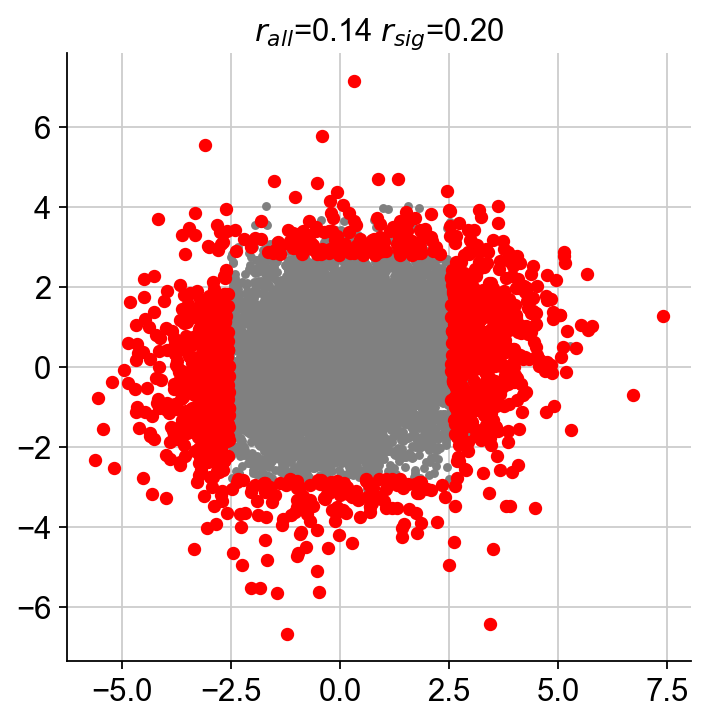

In [29]:
fig, ax = plt.subplots(figsize=(5,5))
sig_mask = (gene1_padj<0.1)|(gene2_padj<0.1)
ax.plot(gene1_zscore[~sig_mask], gene2_zscore[~sig_mask], '.', color='gray')
ax.plot(gene1_zscore[sig_mask], gene2_zscore[sig_mask], '.', color='red', markersize=10)
result_all = pearsonr(gene1_zscore, gene2_zscore)
result_sig = pearsonr(gene1_zscore[sig_mask], gene2_zscore[sig_mask])
ax.set_title(r'$r_{all}$='+f'{result_all.statistic:.2f} '+r'$r_{sig}$='+f'{result_sig.statistic:.2f}')
sns.despine()

In [ ]:
[NDFIP2, PPM1D]	[VAV1, MAF] [ETNK1, MIA3]

In [116]:
genelist2 = ['MIA3', 'TMEM131', 'TLR8', 'PEX3', 'MIA2', 'MFSD8', 'ETNK1', 'DNAJC10', 'CTAGE9', 'CTAGE15', 'CTAGE1']

In [117]:
adata_final[adata_final.obs['target_contrast_gene_name_corrected'].isin(genelist2)].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000150527_Stim48hr,MIA2,Stim48hr,ENSG00000150527,610,567.0,ENSG00000150527,MIA2,40
ENSG00000139163_Rest,ETNK1,Rest,ENSG00000139163,211,473.0,ENSG00000139163,ETNK1,72
ENSG00000154305_Rest,MIA3,Rest,ENSG00000154305,630,121.0,ENSG00000154305,MIA3,72
ENSG00000075568_Rest,TMEM131,Rest,ENSG00000075568,126,809.0,ENSG00000075568,TMEM131,94


In [131]:
adata_final[adata_final.obs['hdbscan']==65].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan
ENSG00000187531_Stim8hr,SIRT7,Stim8hr,ENSG00000187531,129,675.0,ENSG00000187531,SIRT7,65
ENSG00000112697_Stim8hr,TMEM30A,Stim8hr,ENSG00000112697,193,754.0,ENSG00000112697,TMEM30A,65
ENSG00000198182_Stim8hr,ZNF607,Stim8hr,ENSG00000198182,193,705.0,ENSG00000198182,ZNF607,65
ENSG00000164305_Stim8hr,CASP3,Stim8hr,ENSG00000164305,293,1597.0,ENSG00000164305,CASP3,65
ENSG00000072518_Stim8hr,MARK2,Stim8hr,ENSG00000072518,593,403.0,ENSG00000072518,MARK2,65
ENSG00000086062_Stim8hr,B4GALT1,Stim8hr,ENSG00000086062,639,550.0,ENSG00000086062,B4GALT1,65


In [284]:
df_downstream

,hdbscan_cluster,downstream_gene,downstream_gene_ids,num_of_upstream,sign_coherence,zscore_rank_negative_regulation,zscore_rank_positive_regulation
0,37,DPM1,ENSG00000000419,10,-1.000000,578,9579
1,37,SCYL3,ENSG00000000457,22,1.000000,8335,1822
2,37,C1orf112,ENSG00000000460,4,-0.500000,2699,7458
3,37,CFH,ENSG00000000971,2,1.000000,5807,4350
4,37,FUCA2,ENSG00000001036,4,0.500000,4844,5313
...,...,...,...,...,...,...,...
5299,100,TBCE,ENSG00000284770,3,0.333333,3951,1354
5300,100,ARHGAP11B,ENSG00000285077,1,1.000000,3776,1529
5301,100,F8A1,ENSG00000288722,1,1.000000,4156,1148
5302,100,HOMEZ,ENSG00000290292,1,-1.000000,681,4623


In [295]:
df_downstream = pd.read_csv('../../../../3_expts/processed_data/analysis_largefiles/nde30ntotal75_varfiltered_clustering_additional_filtering_downstream_genes.csv', index_col=0)

In [296]:
df_downstream_top = df_downstream[(df_downstream['zscore_rank_negative_regulation']<100)|(df_downstream['zscore_rank_positive_regulation']<100)].copy()

ERROR! Session/line number was not unique in database. History logging moved to new session 1606


In [ ]:
enrichment_df, corum_enrichment_all, stringdb_enrichment_all, kegg_enrichment_all, reactome_enrichment_all, zhang_enrichment_all = run_enrichment_analysis(df_downstream_top, 'hdbscan_cluster', 'downstream_gene')

In [ ]:
enrichment_df.to_parquet('results/clustering_nde30ntotal75.parquet')
enrichment_df.to_csv('results/clustering_nde30ntotal75.csv')
corum_enrichment_all.to_parquet('results/corum_enrichment_nde30ntotal75.parquet')
corum_enrichment_all.to_csv('results/corum_enrichment_nde30ntotal75.csv')
stringdb_enrichment_all.to_parquet('results/stringdb_enrichment_nde30ntotal75.parquet')
stringdb_enrichment_all.to_csv('results/stringdb_enrichment_nde30ntotal75.csv')
kegg_enrichment_all.to_parquet('results/kegg_enrichment_nde30ntotal75.parquet')
kegg_enrichment_all.to_csv('results/kegg_enrichment_nde30ntotal75.csv')
reactome_enrichment_all.to_parquet('results/reactome_enrichment_nde30ntotal75.parquet')
reactome_enrichment_all.to_csv('results/reactome_enrichment_nde30ntotal75.csv')
zhang_enrichment_all.to_parquet('results/zhang_enrichment_nde30ntotal75.parquet')
zhang_enrichment_all.to_csv('results/zhang_enrichment_nde30ntotal75.csv')

In [160]:
de_summary_stats[de_summary_stats.target_name.str.startswith('VAMP')]

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
2815,ENSG00000118640,VAMP8,Rest,584.0,1,1,2,-32.277791,True,258.321340,False,2-10 DE genes,on-target KD,ENSG00000118640,ENSG00000118640_Rest,VAMP8
7706,ENSG00000124333,VAMP7,Rest,1117.0,3,2,5,-25.702397,True,59.534817,True,2-10 DE genes,on-target KD,ENSG00000292366,ENSG00000292366_Rest,VAMP7
7904,ENSG00000117533,VAMP4,Stim8hr,955.0,1,1,2,-13.064954,True,22.155010,False,2-10 DE genes,on-target KD,ENSG00000117533,ENSG00000117533_Stim8hr,VAMP4
7974,ENSG00000168899,VAMP5,Rest,83.0,10,20,30,-5.636993,True,66.618549,False,>10 DE genes,on-target KD,ENSG00000168899,ENSG00000168899_Rest,VAMP5
13752,ENSG00000117533,VAMP4,Rest,909.0,2,2,4,-16.922926,True,44.954339,False,2-10 DE genes,on-target KD,ENSG00000117533,ENSG00000117533_Rest,VAMP4
17736,ENSG00000220205,VAMP2,Stim48hr,930.0,0,1,1,-18.286968,True,51.153634,False,1 DE gene,on-target KD,ENSG00000220205,ENSG00000220205_Stim48hr,VAMP2
17885,ENSG00000220205,VAMP2,Rest,925.0,0,2,2,-19.147603,True,55.201665,False,2-10 DE genes,on-target KD,ENSG00000220205,ENSG00000220205_Rest,VAMP2
18957,ENSG00000124333,VAMP7,Stim8hr,1295.0,7,5,12,-26.066981,True,58.036139,True,>10 DE genes,on-target KD,ENSG00000292366,ENSG00000292366_Stim8hr,VAMP7
20659,ENSG00000139190,VAMP1,Stim8hr,568.0,2,3,5,-11.970747,True,30.810694,False,2-10 DE genes,on-target KD,ENSG00000139190,ENSG00000139190_Stim8hr,VAMP1
26187,ENSG00000220205,VAMP2,Stim8hr,850.0,0,1,1,-16.561089,True,41.178089,False,1 DE gene,on-target KD,ENSG00000220205,ENSG00000220205_Stim8hr,VAMP2


In [130]:
adata_final[adata_final.obs.target_contrast_gene_name_corrected=='MAP4K1'].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan


In [33]:
test_df = adata_final[adata_final.obs.hdbscan==78].obs[['hdbscan', 'target_contrast_gene_name_corrected']]

In [35]:
assess_complex_enrichment(test_df, zhang_complexes, 'hdbscan', 'target_contrast_gene_name_corrected')[0]

""


In [110]:
assess_complex_enrichment(test_df, zhang_pairwise_complexes, 'hdbscan', 'target_contrast_gene_name_corrected')[0]

,cluster,complex,overlap_genes,overlap_fraction,raw_p_value,complex_size,overlap_size,cluster_size
0,72,complex 16523,"[ETNK1, MIA3]",0.010471,1.0,2,2,191


In [102]:
zhang_complexes['complex 262']

{'ALYREF',
 'CCNF',
 'CDK1',
 'CDK2',
 'CTDSPL2',
 'DDX39A',
 'DDX39B',
 'DDX46',
 'EWSR1',
 'FAU',
 'MEIG1',
 'NKX2-1',
 'PRPF6',
 'ZC3H13'}

In [37]:
gene = 'SIT1'
zhang_df[(zhang_df.Name1==gene)|(zhang_df.Name2==gene)]

,Protein1,Protein2,Name1,Name2,RFprob,AFprob,AFprob5,AFMprob,Source,PDBtemp,...,Locality2,Disease1,Disease2,Process1,Process2,Function1,Function2,Exact_templates,Ortho_templates,Homo_templates
5838,P26678,Q9Y3P8,PLN,SIT1,0.2512,0.9126,0.931,0.9400,P,none,...,"Cell membrane,Membrane","Cardiomyopathy,Disease variant",none,none,"Adaptive immunity,Immunity",Cardiac phospholamban,Signaling threshold-regulating transmembrane a...,none,none,none
14925,P20963,Q9Y3P8,CD247,SIT1,0.2695,0.8657,0.843,0.8813,S,none,...,"Cell membrane,Membrane",none,none,"Adaptive immunity,Host-virus interaction,Immunity","Adaptive immunity,Immunity",T-cell surface glycoprotein CD3 zeta chain,Signaling threshold-regulating transmembrane a...,none,none,none


In [102]:
zhang_df[(zhang_df.Name1==gene)|(zhang_df.Name2==gene)][['Name1','Name2']].values.flatten()

array(['PLN', 'SIT1', 'CD247', 'SIT1'], dtype=object)

In [116]:
gene = 'VAV1'
setA = set(zhang_df[(zhang_df.Name1==gene)|(zhang_df.Name2==gene)][['Name1','Name2']].values.flatten()) - set([gene])
gene = 'SNAP29'
setB = set(zhang_df[(zhang_df.Name1==gene)|(zhang_df.Name2==gene)][['Name1','Name2']].values.flatten()) - set([gene])
gene = 'SOS1'
setC = set(zhang_df[(zhang_df.Name1==gene)|(zhang_df.Name2==gene)][['Name1','Name2']].values.flatten()) - set([gene])

In [118]:
setA, setB, setC

({'CBL', 'SLA', 'SOS1'},
 {'SNAP23',
  'STX11',
  'STX12',
  'STX17',
  'STX18',
  'STX19',
  'STX1A',
  'STX1B',
  'STX3',
  'STX4',
  'STX7',
  'VAMP1',
  'VAMP2',
  'VAMP3',
  'VAMP4',
  'VAMP5',
  'VAMP7',
  'VAMP8'},
 {'ABI1',
  'ATRX',
  'BIN1',
  'BLNK',
  'BRD8',
  'CD2AP',
  'EGFR',
  'FOXO1',
  'ITSN1',
  'KITLG',
  'PTPN11',
  'PTPN6',
  'RAP1A',
  'RASL11A',
  'RASL11B',
  'VAV1'})

In [155]:
genelist = ['SNAP29', 'CD3D']
de_summary_stats[de_summary_stats.target_name.isin(genelist)]

,target_contrast,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category,target_contrast_corrected,obs_names,target_name_corrected
13046,ENSG00000099940,SNAP29,Stim48hr,176.0,0,2,2,-7.858750,True,70.591170,True,2-10 DE genes,on-target KD,ENSG00000099940,ENSG00000099940_Stim48hr,SNAP29
13194,ENSG00000099940,SNAP29,Rest,183.0,17,2,19,-9.553305,True,68.825046,True,>10 DE genes,on-target KD,ENSG00000099940,ENSG00000099940_Rest,SNAP29
17943,ENSG00000099940,SNAP29,Stim8hr,166.0,370,37,407,-7.036317,True,46.680143,True,>10 DE genes,on-target KD,ENSG00000099940,ENSG00000099940_Stim8hr,SNAP29
21819,ENSG00000167286,CD3D,Stim8hr,185.0,3491,1493,4984,-14.856732,True,421.369093,True,>10 DE genes,on-target KD,ENSG00000167286,ENSG00000167286_Stim8hr,CD3D
29001,ENSG00000167286,CD3D,Rest,193.0,5,2,7,-17.429508,True,351.581940,True,2-10 DE genes,on-target KD,ENSG00000167286,ENSG00000167286_Rest,CD3D
31698,ENSG00000167286,CD3D,Stim48hr,85.0,1016,416,1432,-2.457642,False,367.741385,True,>10 DE genes,putative off-target,ENSG00000167286,ENSG00000167286_Stim48hr,CD3D


In [156]:
adata_final[adata_final.obs['target_contrast_gene_name_corrected'].isin(genelist)].obs

,target_contrast_gene_name,culture_condition,target_contrast,chunk,n_cells_target,target_contrast_corrected,target_contrast_gene_name_corrected,hdbscan,hdbscan_cluster_size,hdbscan_cluster_gene_size,hdbscan_corr_rest_over_corr_all,hdbscan_corr_stim8hr_over_corr_all,hdbscan_corr_stim48hr_over_corr_all
ENSG00000099940_Stim8hr,SNAP29,Stim8hr,ENSG00000099940,359,166.0,ENSG00000099940,SNAP29,37,124,124,0.297798,3.165677,1.342780
ENSG00000167286_Stim48hr,CD3D,Stim48hr,ENSG00000167286,634,85.0,ENSG00000167286,CD3D,109,169,169,0.608462,0.958739,3.193629
ENSG00000167286_Stim8hr,CD3D,Stim8hr,ENSG00000167286,436,185.0,ENSG00000167286,CD3D,37,124,124,0.297798,3.165677,1.342780


In [3]:
adata_de = sc.read_h5ad('../../../../3_expts/processed_data/CD4i_final/DE_results_all_confounders/CD4i_final.merged_DE_results_corrected.h5ad')
adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
adata_de.X = np.nan_to_num(adata_de.layers['zscore'], 0)

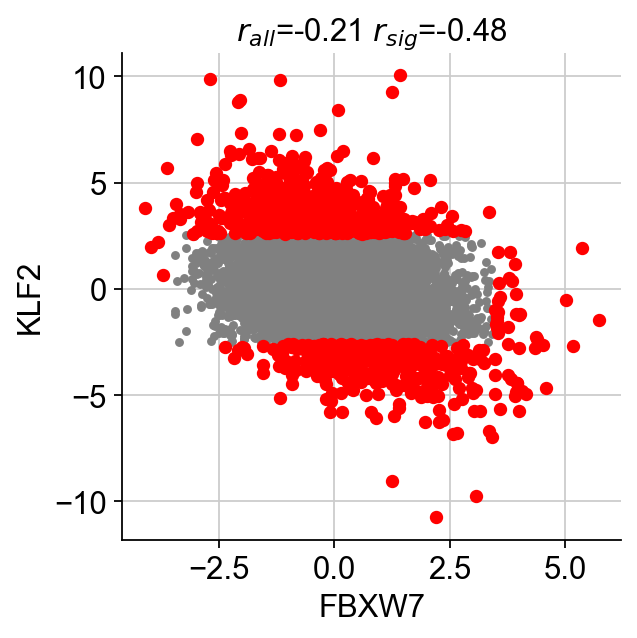

In [43]:
genelist =['FBXW7', 'KLF2']
cond_mask = adata_de.obs['culture_condition']=='Rest'
target_gene_mask = ~adata_de.var['gene_name'].isin(genelist)
gene1_zscore = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[0]),target_gene_mask].layers['zscore'][0].copy()
gene1_padj = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[0]),target_gene_mask].layers['adj_p_value'][0].copy()
gene2_zscore = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[1]),target_gene_mask].layers['zscore'][0].copy()
gene2_padj = adata_de[cond_mask&(adata_de.obs['target_contrast_gene_name_corrected']==genelist[1]),target_gene_mask].layers['adj_p_value'][0].copy()
fig, ax = plt.subplots(figsize=(4,4))
sig_mask = (gene1_padj<0.1)|(gene2_padj<0.1)
ax.plot(gene1_zscore[~sig_mask], gene2_zscore[~sig_mask], '.', color='gray')
ax.plot(gene1_zscore[sig_mask], gene2_zscore[sig_mask], '.', color='red', markersize=10)
ax.set_xlabel(genelist[0])
ax.set_ylabel(genelist[1])
result_all = pearsonr(gene1_zscore, gene2_zscore)
result_sig = pearsonr(gene1_zscore[sig_mask], gene2_zscore[sig_mask])
ax.set_title(r'$r_{all}$='+f'{result_all.statistic:.2f} '+r'$r_{sig}$='+f'{result_sig.statistic:.2f}')
sns.despine()

In [112]:
de_by_guide[de_by_guide.target.isin(genelist)]

,target,correlation,correlation_ceiling,n_signif,culture_condition
267,ETNK1,0.782226,0.805179,38,Rest


In [113]:
donor_robustness_summary[donor_robustness_summary.target_name.isin(genelist)]

,target_name,donor_correlation_mean,donor_correlation_min,target_contrast,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
267,ETNK1,0.627501,0.442585,ENSG00000139163,Rest,473.0,195,105,300,-10.234285,True,34.638801,False,>10 DE genes,on-target KD
